# Ungraded Lab: Using more sophisticated images with Convolutional Neural Networks

## Download and Inspect the Dataset

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-07-25 14:22:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  17.4MB/s    in 4.4s    

2024-07-25 14:22:54 (15.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import zipfile

# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
import os

base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'vectorize.py', 'train']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.613.jpg', 'cat.604.jpg', 'cat.898.jpg', 'cat.181.jpg', 'cat.958.jpg', 'cat.988.jpg', 'cat.815.jpg', 'cat.290.jpg', 'cat.71.jpg', 'cat.73.jpg']
['dog.478.jpg', 'dog.764.jpg', 'dog.493.jpg', 'dog.108.jpg', 'dog.135.jpg', 'dog.367.jpg', 'dog.105.jpg', 'dog.147.jpg', 'dog.969.jpg', 'dog.227.jpg']


In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

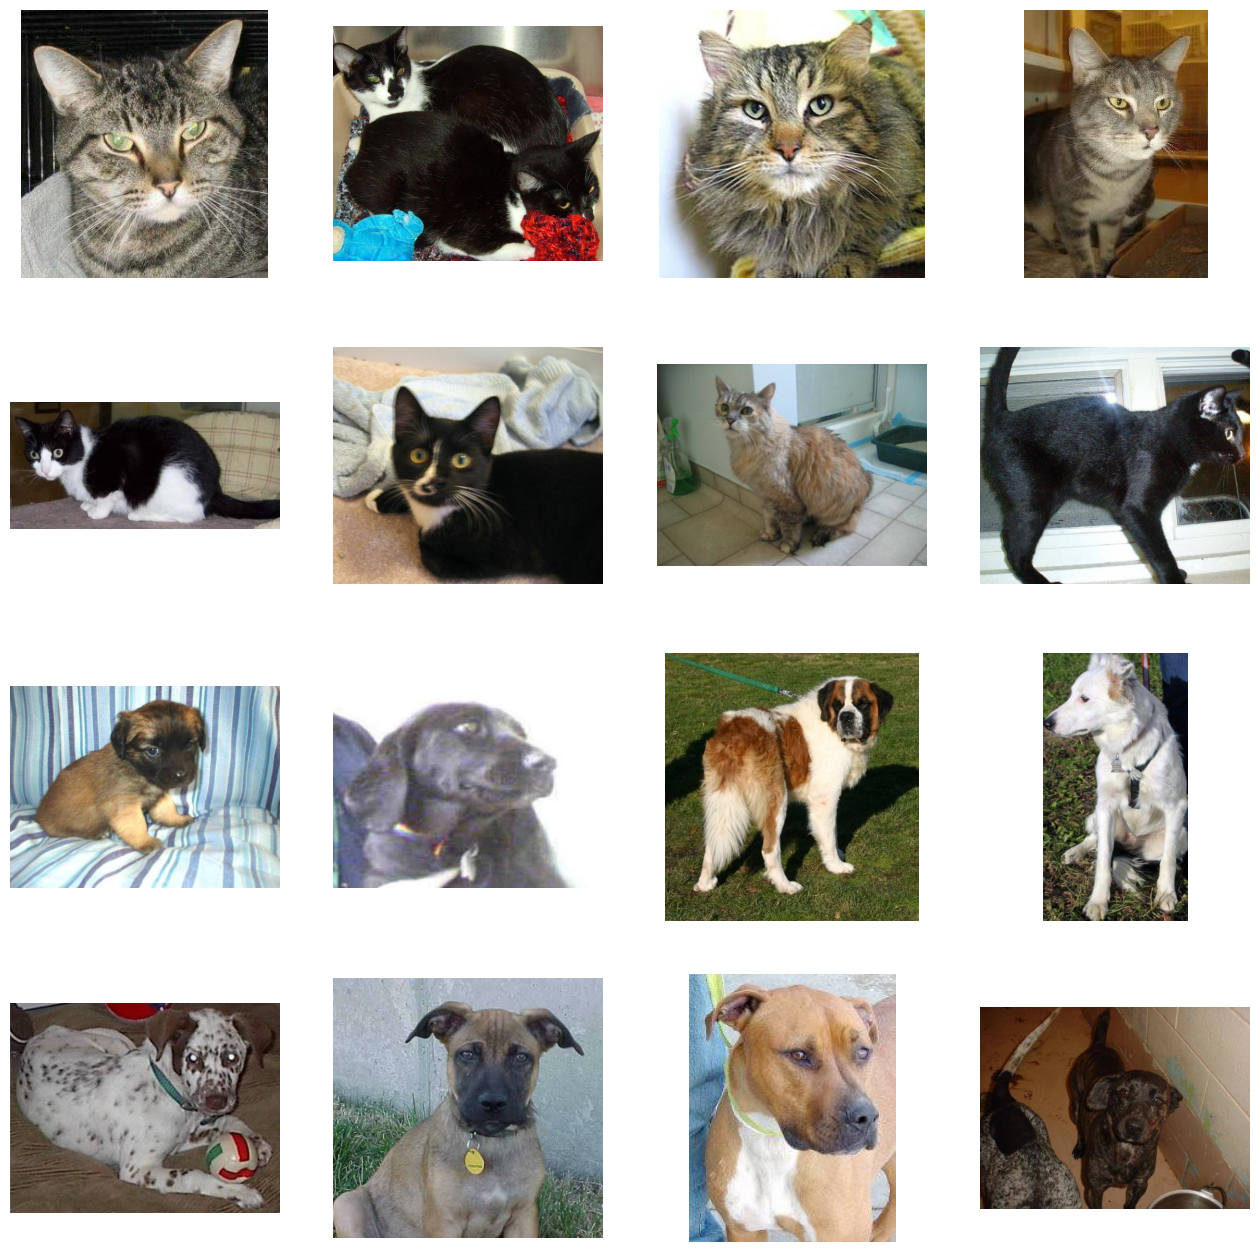

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch to get to ~72% Accuracy

In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training

In [14]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 13s - loss: 0.7146 - accuracy: 0.5515 - val_loss: 0.6520 - val_accuracy: 0.6120 - 13s/epoch - 132ms/step
Epoch 2/15
100/100 - 6s - loss: 0.6208 - accuracy: 0.6555 - val_loss: 0.6021 - val_accuracy: 0.6500 - 6s/epoch - 56ms/step
Epoch 3/15
100/100 - 7s - loss: 0.5750 - accuracy: 0.7025 - val_loss: 0.6020 - val_accuracy: 0.6600 - 7s/epoch - 66ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5151 - accuracy: 0.7640 - val_loss: 0.5255 - val_accuracy: 0.7380 - 5s/epoch - 53ms/step
Epoch 5/15
100/100 - 6s - loss: 0.4549 - accuracy: 0.7800 - val_loss: 0.6013 - val_accuracy: 0.6920 - 6s/epoch - 57ms/step
Epoch 6/15
100/100 - 5s - loss: 0.3794 - accuracy: 0.8255 - val_loss: 0.5963 - val_accuracy: 0.7190 - 5s/epoch - 46ms/step
Epoch 7/15
100/100 - 7s - loss: 0.3081 - accuracy: 0.8670 - val_loss: 0.6074 - val_accuracy: 0.7300 - 7s/epoch - 70ms/step
Epoch 8/15
100/100 - 5s - loss: 0.2301 - accuracy: 0.9025 - val_loss: 0.6501 - val_accuracy: 0.7420 - 5s/epoch - 45ms/step
Epoch 9/15
10

### Model Prediction

In [18]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving pets-3715733_640.jpg to pets-3715733_640.jpg
1/1 [==============================] - 0s 17ms/step
[0.8088635]
pets-3715733_640.jpg is a dog


In [ ]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = load_img(path, target_size=(150, 150))
#  x = img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a dog")
#  else:
#    print(i + " is a cat")

### Visualizing Intermediate Representations

1/1 [==============================] - 0s 127ms/step


<ipython-input-19-ef37dc9124ee>:48: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
<ipython-input-19-ef37dc9124ee>:51: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


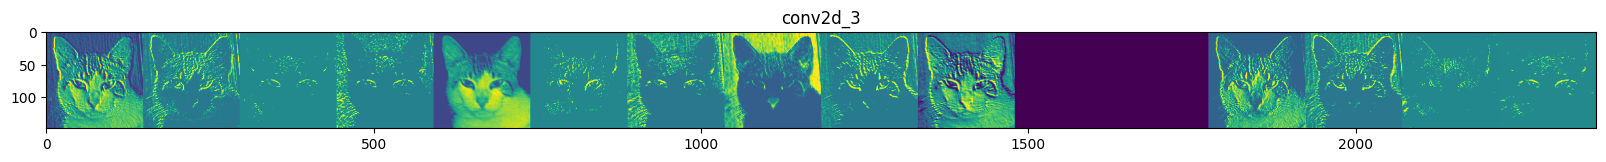

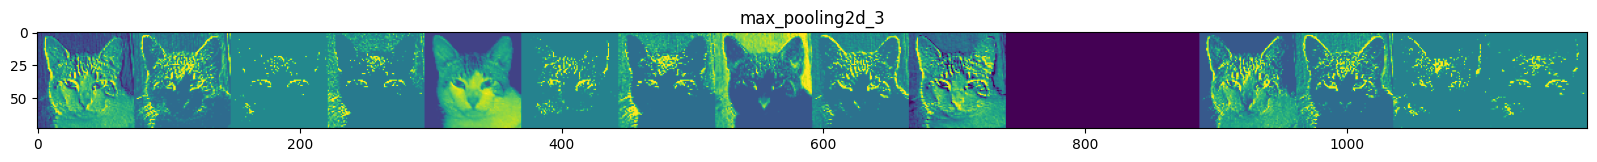

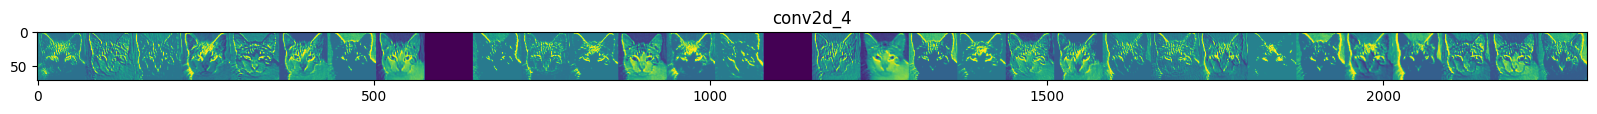

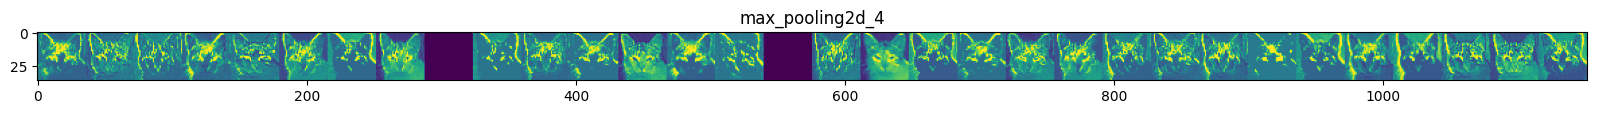

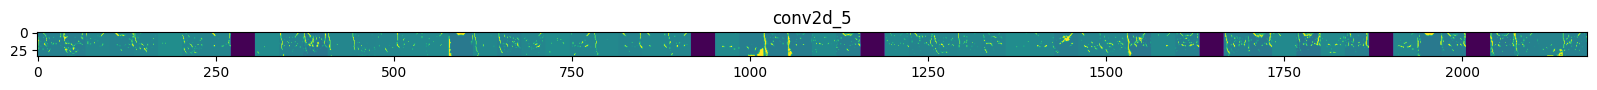

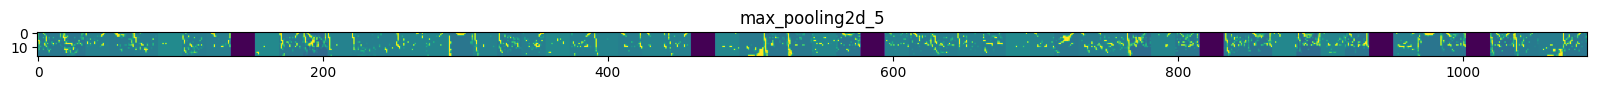

In [19]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

### Evaluating Accuracy and Loss for the Model

In [22]:
# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc      = history.history[     'accuracy' ]
# val_acc  = history.history[ 'val_accuracy' ]
# loss     = history.history[    'loss' ]
# val_loss = history.history['val_loss' ]

# epochs   = range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     acc )
# plt.plot  ( epochs, val_acc )
# plt.title ('Training and validation accuracy')
# plt.legend()
# plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     loss )
# plt.plot  ( epochs, val_loss )
# plt.title ('Training and validation loss'   )
# plt.legend()

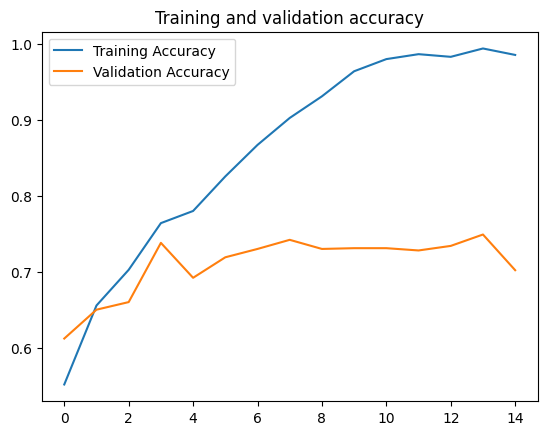

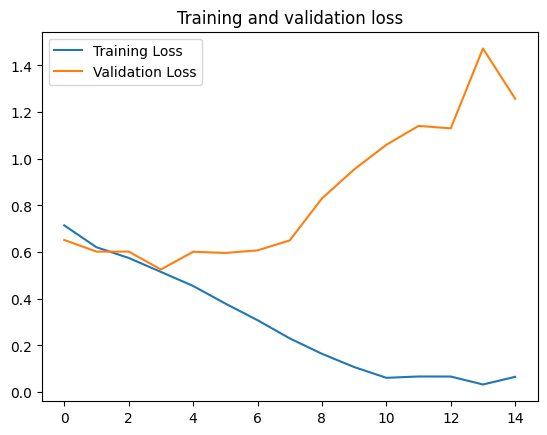

In [23]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# Show the plots
plt.show()


## Clean Up


In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

In [ ]:
# from google.colab import runtime
# runtime.unassign()